# Question 10

Basic Settings

In [1]:
import os
from time import time, clock
from datetime import datetime


import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data


import numpy as np
import sklearn

/anaconda/envs/ml_env/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# a.Building neuro net

## The neuro networks

#### Setting Constant

In [2]:
n_input_AB = 28 * 28
n_hidden_AB = 100
n_hidden = 20
n_outputs_AB = 100
n_outputs = 2
n_layer_AB = 3
kernel_regularizer = None

learning_rate = 0.005

base_dir = os.path.join(".", "temp")

#### Set The graph

In [3]:
try:
    del graph
    print("Deleting old graph")
except:
    pass
print("Making new graph")
graph = tf.Graph()

time_str = datetime.now().strftime("%Y%m%d%H%M%S")
log_dir = os.path.join(base_dir, "logs", time_str)
save_dir = os.path.join(base_dir, "saves", time_str)

Making new graph


### Network A

In [4]:
with graph.as_default():
    
    with tf.name_scope("inputs_A"):
        X_A = tf.placeholder(
                            tf.float32,
                            shape=[None, n_input_AB],
                            name="X_A"
                            )
        tf.add_to_collection("feed_vars_A", X_A)

        training_A = tf.placeholder_with_default(
                                                False,
                                                [],
                                                name="training_A"
                                            )
        tf.add_to_collection("feed_vars_A", training_A)

    
    inputs_A = X_A
    
    with tf.name_scope("dnn_A"):
        for i in range(1, n_layer_AB+1):

            inputs_A = tf.layers.dense(
                                    inputs_A,
                                    n_hidden_AB,
                                    activation=tf.nn.selu,
                                    use_bias=True,
                                    kernel_initializer=kernel_regularizer,
                                    bias_initializer=tf.zeros_initializer(),
                                    kernel_regularizer=None,
                                    bias_regularizer=None,
                                    activity_regularizer=None,
                                    kernel_constraint=None,
                                    bias_constraint=None,
                                    trainable=True,
                                    name="hidden{}_A".format(i),
                                    reuse=None
                                )
            tf.add_to_collection("hidden_A", inputs_A)

### Network B

In [5]:
with graph.as_default():
    with tf.name_scope("inputs_B"):
        X_B = tf.placeholder(
                            tf.float32,
                            shape=[None, n_input_AB],
                            name="X_B"
                            )
        tf.add_to_collection("feed_vars_B", X_B)

        training_B = tf.placeholder_with_default(
                                                False,
                                                [],
                                                name="training_B"
                                            )
        tf.add_to_collection("feed_vars_B", training_B)

    
    inputs_B = X_B
    
    with tf.name_scope("dnn_B"):
        for i in range(1, n_layer_AB+1):

            inputs_B = tf.layers.dense(
                                    inputs_B,
                                    n_hidden_AB,
                                    activation=tf.nn.selu,
                                    use_bias=True,
                                    kernel_initializer=kernel_regularizer,
                                    bias_initializer=tf.zeros_initializer(),
                                    kernel_regularizer=None,
                                    bias_regularizer=None,
                                    activity_regularizer=None,
                                    kernel_constraint=None,
                                    bias_constraint=None,
                                    trainable=True,
                                    name="hidden{}_B".format(i),
                                    reuse=None
                                )
            tf.add_to_collection("hidden_B", inputs_B)    

### Output layer and Other ops

In [6]:
with graph.as_default():
    with tf.name_scope("inputs"):
        y = tf.placeholder(tf.int32, [None, n_outputs], name='y')
        tf.add_to_collection("feed_vars", y)

    
    with tf.name_scope("logits"):
        inputs = tf.concat(
                        [inputs_A, inputs_B],
                        axis=1,
                        name="inputs"
                    )
        tf.add_to_collection("logits", inputs)

        hidden1 = tf.layers.dense(
                            inputs,
                            n_hidden,
                            activation=tf.nn.selu,
                            use_bias=True,
                            kernel_initializer=None,
                            bias_initializer=tf.zeros_initializer(),
                            kernel_regularizer=kernel_regularizer,
                            bias_regularizer=None,
                            activity_regularizer=None,
                            kernel_constraint=None,
                            bias_constraint=None,
                            trainable=True,
                            name="hidden1",
                            reuse=None
                        )
        
        
        logits = tf.layers.dense(
                            hidden1,
                            n_outputs,
                            activation=None,
                            use_bias=True,
                            kernel_initializer=None,
                            bias_initializer=tf.zeros_initializer(),
                            kernel_regularizer=kernel_regularizer,
                            bias_regularizer=None,
                            activity_regularizer=None,
                            kernel_constraint=None,
                            bias_constraint=None,
                            trainable=True,
                            name="logits",
                            reuse=None
                        )
        tf.add_to_collection("logits", logits)
    
    
    with tf.name_scope("outputs"):
        y_prob = tf.nn.softmax(
                            logits,
                            axis=-1,
                            name="y_prob",
                        )
        tf.add_to_collection("prediction", y_prob)

        y_pred = tf.argmax(
                        # The logtis is enough for determining the best one
                        # don't need add additional calculation of y_prob
                        logits,
                        axis=1,
                        name="y_pred",
                    )
        tf.add_to_collection("prediction", y_pred)

        
    with tf.name_scope("metrics"):
        true_labels = tf.argmax(
                                y,
                                axis=1,
                                name="true_labels",
                               )
        tf.add_to_collection("metrics", true_labels)
        
        
#         xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
#                                                          labels=true_labels,
#                                                          logits=logits,
#                                                          name="xentropy"
#                                                          )

        xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(
                                                        labels=y,
                                                        logits=logits,
                                                        name="xentropy"
                                                    )
        base_loss = tf.reduce_mean(xentropy, name="base_loss")
        reg_loss = tf.get_collection(
            tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([base_loss]+reg_loss, name="loss")
        tf.add_to_collection("metrics", base_loss)
        tf.add_to_collection("metrics", loss)


        correct = tf.nn.in_top_k(logits, true_labels, 1, name="correct")
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), 
                                  name="accuracy")
        tf.add_to_collection("metrics", correct)
        tf.add_to_collection("metrics", accuracy)

    
    
    with tf.name_scope("training"):
        optimizer = tf.train.AdamOptimizer(
                                learning_rate=learning_rate,
                            )
        training_op = optimizer.minimize(loss)
        tf.add_to_collection("training", training_op)
        
    
    with tf.name_scope("saver"):
        saver = tf.train.Saver(name="saver")


    with tf.name_scope("logging"):
        file_writer = tf.summary.FileWriter(
                                            log_dir,
                                            graph=None,
                                            max_queue=10,
                                            flush_secs=120,
                                            graph_def=None,
                                            filename_suffix=None
                                        )
        
        training_loss_log = tf.summary.scalar(
                                            "loss_log",
                                            loss,
                                            collections=[tf.GraphKeys.SUMMARIES, 
                                                         "logging"],
                                            family="training"
                                        )
        
        training_acc_log = tf.summary.scalar(
                                            "acc_log",
                                            accuracy,
                                            collections=[tf.GraphKeys.SUMMARIES, 
                                                         "logging"],
                                            family="training"
                                        )
        
        valid_loss_log = tf.summary.scalar(
                                            "loss_log",
                                            loss,
                                            collections=[tf.GraphKeys.SUMMARIES, 
                                                         "logging"],
                                            family="validation"
                                        )
        
        valid_acc_log = tf.summary.scalar(
                                            "acc_log",
                                            accuracy,
                                            collections=[tf.GraphKeys.SUMMARIES, 
                                                         "logging"],
                                            family="validation"
                                        )
        
    with tf.name_scope("initializer"):
        initializers = tf.group(tf.global_variables_initializer(),
                                        tf.local_variables_initializer())

# b.Data Prep

We need to create our training data in order to proceed

### 1. Extract the data

In [58]:
mnist = input_data.read_data_sets("./temp/datasets/")
X_train = mnist.train.images
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels
X_valid = mnist.validation.images
y_valid = mnist.validation.labels

rnd_select_index=np.random.permutation(55000)

X_train_1, X_train_2 = X_train[:55000], X_train[rnd_select_index[:5000]]
y_train_1, y_train_2 = y_train[:55000], y_train[rnd_select_index[:5000]]

Extracting ./temp/datasets/train-images-idx3-ubyte.gz
Extracting ./temp/datasets/train-labels-idx1-ubyte.gz
Extracting ./temp/datasets/t10k-images-idx3-ubyte.gz
Extracting ./temp/datasets/t10k-labels-idx1-ubyte.gz


### Creating batching function

In [8]:
def make_batch(X, y, batch_size, epoch_num=1, batch_num=1, state=42):
    shape_X = [batch_size, 28 * 28]
    shape_y = [batch_size, 2]
    
    data_size = X.shape[0]
    np.random.seed((epoch_num * batch_size - batch_num * state)%(2**32-1))
    c_same = 0
    c_diff = 0
    
    X_batch_1=np.empty(shape_X, dtype=float, order='C')
    X_batch_2=np.empty(shape_X, dtype=float, order='C')
    y_batch=np.empty(shape_y, dtype=float, order='C')
    while c_same + c_diff < batch_size:
        if c_same >= batch_size // 2:
            
            rnd1 = np.random.randint(data_size)
            rnd2 = np.random.randint(data_size)
            
            while y[rnd1] == y[rnd2]:
                rnd2 = np.random.randint(data_size)
            
            X_batch_1[c_same+c_diff]=X[rnd1]
            X_batch_2[c_same+c_diff]=X[rnd2]
            y_batch[c_same+c_diff]=[0, 1]
            
            c_diff += 1
            
        elif c_diff >= batch_size // 2:

            rnd1 = np.random.randint(data_size)
            rnd2 = np.random.randint(data_size)
            
            while y[rnd1] != y[rnd2]:
                rnd2 = np.random.randint(data_size)
            
            X_batch_1[c_same+c_diff]=X[rnd1]
            X_batch_2[c_same+c_diff]=X[rnd2]
            y_batch[c_same+c_diff]=[1, 0]
            
            c_same += 1
            
        else:
            
            rnd1 = np.random.randint(data_size)
            rnd2 = np.random.randint(data_size)
            
            is_same = (y[rnd1] == y[rnd2])

            
            X_batch_1[c_same+c_diff]=X[rnd1]
            X_batch_2[c_same+c_diff]=X[rnd2]
            y_batch[c_same+c_diff]=[0, 1] if (is_same == False) else [1, 0]

            c_diff += (is_same == False)
            c_same += (is_same == True)
    rnd_ind = np.random.permutation(batch_size)
    return X_batch_1[rnd_ind], X_batch_2[rnd_ind], y_batch[rnd_ind]

# c. Training DNN

In [11]:
n_epoch = 100
batch_size = 1000
log_freq = 3
training_num = X_train_1.shape[0]

if not os.path.isdir(log_dir):
    os.makedirs(log_dir)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

In [12]:
num_batch = np.ceil(training_num/batch_size).astype(int)
with graph.as_default():
    with tf.Session(graph=graph) as sess:
        c_drop = 0
        c_max = 5
        
        max_acc = 0
        
        initializers.run()
        
        file_writer.add_graph(tf.get_default_graph())
        
        for epoch in range(1, n_epoch+1):
            for batch in range(1, num_batch+1):
                X_batch_1, X_batch_2, y_batch = make_batch(X_train_1, 
                                                           y_train_1, 
                                                           batch_size, 
                                                           epoch, 
                                                           batch
                                                          )
                training_op.run(feed_dict={X_A:X_batch_1,
                                           X_B:X_batch_2,
                                           y:y_batch}
                               )
            
            if not epoch % log_freq:
                save_path = \
                    saver.save(sess, 
                               os.path.join(save_dir, 
                                            "{}.ckpt".format(epoch/log_freq)
                                           )
                              )
                X_batch_1, X_batch_2, y_batch = make_batch(X_train_1, 
                                                           y_train_1, 
                                                           X_train_1.shape[0]//3, 
                                                           epoch, 
                                                           batch
                                                          )

                training_loss, training_acc, \
                log_training_loss, log_training_acc = \
                                        sess.run([loss, 
                                                  accuracy, 
                                                  training_loss_log, 
                                                  training_acc_log], 
                                                 feed_dict={X_A:X_batch_1,
                                                            X_B:X_batch_2,
                                                            y:y_batch})
                    
#                 training_loss, training_acc,\
#                 log_training_loss, log_training_acc,\
#                 train_inputs_A, train_inputs_B, train_input, train_pred, \
#                 train_prob, train_label, train_correct, train_logits,\
#                 train_entropy= \
#                                         sess.run([loss, 
#                                                   accuracy, 
#                                                   training_loss_log, 
#                                                   training_acc_log,
#                                                   inputs_A,
#                                                   inputs_B,
#                                                   inputs,
#                                                   y_pred,
#                                                   y_prob,
#                                                   true_labels,
#                                                   correct,
#                                                   logits,
#                                                   xentropy
#                                                  ], 
#                                                  feed_dict={X_A:X_batch_1,
#                                                             X_B:X_batch_2,
#                                                             y:y_batch})

#                 print("pred", train_pred[:5])
#                 print("prob", train_prob[:5])
#                 print("label",train_label[:5])
#                 print("correct", train_correct[:5])
#                 print(np.unique(train_correct, return_counts=True))
                
                
                X_val_1, X_val_2, y_val = make_batch(X_valid, 
                                                     y_valid, 
                                                     X_valid.shape[0]
                                                    )
                valid_loss, valid_acc, log_valid_loss, log_valid_acc = \
                                        sess.run([loss, 
                                                  accuracy, 
                                                  valid_loss_log, 
                                                  valid_acc_log], 
                                                 feed_dict={X_A:X_val_1,
                                                            X_B:X_val_2,
                                                            y:y_val})
                
                file_writer.add_summary(log_training_loss, epoch * num_batch)
                file_writer.add_summary(log_training_acc, epoch * num_batch)
                file_writer.add_summary(log_valid_loss, epoch * num_batch)
                file_writer.add_summary(log_valid_acc, epoch * num_batch)
                
                
                
                print("epoch: {:<3}Training accuracy: {:<6.4f}, \n\
                  Training loss: {:<6.6f}\n\
                                            Validation accuracy: {:<6.4f}\n\
                                                Validation loss: {:<6.6f}"
                          .format(epoch, training_acc, training_loss, 
                                  valid_acc, valid_loss))
                if valid_acc >= max_acc:
                    max_acc = valid_acc
                    c_drop = 0
                    final_save_path = save_path
                else:
                    c_drop += 1
                
                if c_drop >= c_max:
                    print("Early Stopping!")
                    break

epoch: 3  Training accuracy: 0.8091, 
                  Training loss: 0.420722
                                            Validation accuracy: 0.8000
                                                Validation loss: 0.436135
epoch: 6  Training accuracy: 0.8952, 
                  Training loss: 0.254889
                                            Validation accuracy: 0.8894
                                                Validation loss: 0.266316
epoch: 9  Training accuracy: 0.9336, 
                  Training loss: 0.171562
                                            Validation accuracy: 0.9298
                                                Validation loss: 0.168983
epoch: 12 Training accuracy: 0.9564, 
                  Training loss: 0.116516
                                            Validation accuracy: 0.9514
                                                Validation loss: 0.122248
epoch: 15 Training accuracy: 0.9596, 
                  Training loss: 0.109162
                

### Let's do a test

In [13]:
import matplotlib.pyplot as plt

In [14]:
X_batch_1, X_batch_2, y_batch = make_batch(X_test, 
                                           y_test, 
                                           X_test.shape[0]//2
                                          )

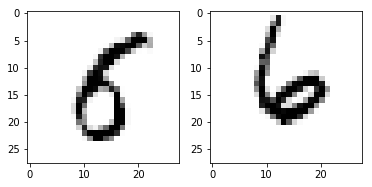

same image


In [28]:
ind = np.random.randint(500)
img1 = X_batch_1[ind].reshape(28,28)
img2 = X_batch_2[ind].reshape(28,28)
result = np.argmax(y_batch[ind])

plt.subplot(121)
plt.imshow(img1, cmap="Greys")
plt.subplot(122)
plt.imshow(img2, cmap="Greys")
plt.show()

if result:
    print("different image")
    
if not result:
    print("same image")

In [27]:
final_save_path = './temp/saves/20180201172009/18.0.ckpt'

In [29]:
with graph.as_default():
    with tf.Session() as sess:
#         sess.run(initializers)
        saver.restore(sess, final_save_path)
        
        pred = sess.run(y_pred, feed_dict={
                X_A: img1.reshape(1,-1), X_B: img2.reshape(1,-1)
            })
if pred:
    print("different image")

if not pred:
    print("same image")

INFO:tensorflow:Restoring parameters from ./temp/saves/20180201172009/18.0.ckpt
same image


In [24]:
with graph.as_default():
    with tf.Session() as sess:
#         sess.run(initializers)
        saver.restore(sess, final_save_path)
        X_batch_1, X_batch_2, y_batch = make_batch(X_test, 
                                                   y_test, 
                                                   X_test.shape[0]//2
                                                  )
        acc = sess.run(accuracy, feed_dict={
                X_A: X_batch_1, X_B: X_batch_2, y:y_batch
            })
print(acc)

INFO:tensorflow:Restoring parameters from ./temp/saves/20180201172009/18.0.ckpt
0.9788


# d.Transfer learning

In [131]:
try:
    del graph
except:
    pass
graph = tf.Graph()
with graph.as_default():
    saver = tf.train.import_meta_graph(final_save_path+".meta")

In [132]:
with graph.as_default():
    X_A = tf.get_collection("feed_vars_A",scope=".*X_A:0")[0]
    A_vars = graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 
                                  scope="hidden[1-3]_A")
    y = tf.placeholder(tf.int32, name="new_y")
    inputs_A = tf.get_collection("hidden_A")[2]
    frozen_outputs = tf.stop_gradient(inputs_A)
    logits = tf.layers.dense(
                    inputs_A,
                    10,
                    activation=None,
                    use_bias=True,
                    kernel_initializer=None,
                    bias_initializer=tf.zeros_initializer(),
                    kernel_regularizer=kernel_regularizer,
                    bias_regularizer=None,
                    activity_regularizer=None,
                    kernel_constraint=None,
                    bias_constraint=None,
                    trainable=True,
                    name="logits",
                    reuse=None
                )
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
                                                    labels=y,
                                                    logits=logits,
                                                    name="xentropy"
                                                )
    loss = tf.reduce_mean(xentropy, name="loss")
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name="new_optimizer")
    training_op = optimizer.minimize(loss)
    
    correct = tf.cast(tf.nn.in_top_k(logits, y, 1, name="new_correct"), tf.float32)
    accuracy = tf.reduce_mean(correct, name="new_acc")
#     print(A_vars)
#     for var in A_vars:
#         print("======================")
#         print(var.op)
#         print(var.op.name)
#         print("======================")
    res_saver = tf.train.Saver(var_list={var.op.name: var for var in A_vars})
    
    initializer = tf.global_variables_initializer()
    

In [133]:
n_epoch = 100
batch_size = 100
log_freq = 3
training_num = X_train_1.shape[0]

In [134]:
print(X_train_2.shape)

(5000, 784)


In [136]:
time_now = datetime.now().strftime("%Y%m%d%H%M%S")

new_save_dir = os.path.join(base_dir, "transfer", time_now)

if not os.path.isdir(new_save_dir):
    os.makedirs(new_save_dir)

with graph.as_default():
    with tf.Session(graph=graph) as sess:
        c_drop = 0
        c_max = 5
        
        max_acc = 0
        
        initializer.run()
        res_saver.restore(sess, final_save_path)
        
        for epoch in range(1, n_epoch+1):
            training_op.run(feed_dict={X_A:X_train_2,
                                       y:y_train_2}
                           )
            
            if not epoch % log_freq:
                save_path = \
                    saver.save(sess, 
                               os.path.join(new_save_dir, 
                                            "{}.ckpt".format(epoch/log_freq)
                                           )
                              )

                training_loss = sess.run(loss, 
                                        feed_dict={X_A:X_train_2,
                                                   y:y_train_2})

                valid_acc = sess.run(accuracy,
                                     feed_dict={X_A:X_valid,
                                               y:y_valid})
                
                
                
                print("epoch: {:<3}Training loss: {:<6.6f}\n\
                                            Validation accuracy: {:<6.4f}\n"
                          .format(epoch,training_loss, 
                                  valid_acc))
                if valid_acc >= max_acc:
                    max_acc = valid_acc
                    c_drop = 0
                    final_save_path = save_path
                else:
                    c_drop += 1
                
                if c_drop >= c_max:
                    print("Early Stopping!")
                    break

INFO:tensorflow:Restoring parameters from ./temp/transfer/20180202001149/4.0.ckpt
epoch: 3  Training loss: 0.648311
                                            Validation accuracy: 0.7924

epoch: 6  Training loss: 0.285135
                                            Validation accuracy: 0.9120

epoch: 9  Training loss: 0.148013
                                            Validation accuracy: 0.9472

epoch: 12 Training loss: 0.136692
                                            Validation accuracy: 0.9486

epoch: 15 Training loss: 0.118657
                                            Validation accuracy: 0.9506

epoch: 18 Training loss: 0.071435
                                            Validation accuracy: 0.9560

epoch: 21 Training loss: 0.045563
                                            Validation accuracy: 0.9606

epoch: 24 Training loss: 0.034160
                                            Validation accuracy: 0.9614

epoch: 27 Training loss: 0.024357
                            

#### We got 96 near 97% accuracy!